# Arbor-Neuron validation output analysis

In [1]:
import re
import json
import pandas
import matplotlib.pyplot as plt
from IPython.display import display

Tests with OK status:

In [2]:
%%bash

rm tests_{ok,error,na} || true
grep test_l5pc\ OK l5pc_validate_neuron_arbor_* | tee tests_ok

rm: cannot remove 'tests_ok': No such file or directory
rm: cannot remove 'tests_error': No such file or directory
rm: cannot remove 'tests_na': No such file or directory


l5pc_validate_neuron_arbor_all.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00101 (0.05), 1.7e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_all.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000381 (0.05), 2.13e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.003 (0.05), 7.63e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000692 (0.05), 1.79e-06 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im_NaTs2_t.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00423 (0.05), 7.88e-08 (0.0005).\n"
l5pc_validat

Tests with ERROR status:

In [3]:
%%bash

grep test_l5pc\ ERROR l5pc_validate_neuron_arbor_* | tee tests_error

l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Pst_NaTa_t.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.0574 (0.05), 3.4e-07 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.593 (0.05), 2.52e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.593 (0.05), 2.8e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst_NaTa_t.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.52 (0.05), 3.37e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst_NaTa_t.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative A

Tests with N/A result:

In [4]:
%%bash

touch tests_na
for f in $(ls l5pc_validate_neuron_arbor_*); do 
    if ! grep test_l5pc\ OK $f > /dev/null && ! grep test_l5pc\ ERROR $f > /dev/null; then 
        echo "$f" | tee -a tests_na
    fi
done

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2_SK_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_SK_E2_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_SK_E2_CaDynamics_E2_Ca_LVAst

In [5]:
# Read output
with open('tests_ok') as f:
    tests_ok = f.readlines()

with open('tests_error') as f:
    tests_error = f.readlines()

with open('tests_na') as f:
    tests_na = f.readlines()

Display test results. Test status can be ERROR due to relative L1-norm exceeding the tolerance or, similarly, the quadrature error exceeding a lower threshold. 

In [6]:
def parse_test_status_line(line):
    numeric_vars = ['dt', 'l1_norm', 'l1_tol', 'l1_error', 'l1_error_tol']
    numbers = [r'(?P<{}>[+\-]?\d+[\.]?\d*[eE]?[+\-]?\d*)'.format(name) 
               for name in numeric_vars]
    test_status_pattern = r'^(?P<filename>l5pc_validate_neuron_arbor_\w+.ipynb):\s+\"(?P<dt_setting>Default|Fine) dt \({}\): test_l5pc (?P<test_result>OK|ERROR)! [\w\s-]+\(tol in brackets\) are {} \({}\), {} \({}\)'.format(*numbers)
    match = re.search(test_status_pattern, line)
    groupdict = match.groupdict()
    for v in numeric_vars:
        groupdict[v] = float(groupdict[v])
    return groupdict


# extract params from executed notebooks
def extract_mechs_params(filename):
    with open(filename) as f:
        nb = json.load(f)
    # print(nb['cells'][2]['source'])
    exec('global mechanism_defs\nglobal extra_params\n' + ''.join(nb['cells'][2]['source']))
    return mechanism_defs, extra_params


test_results = []
for line in tests_ok + tests_error:
    result = parse_test_status_line(line)
    region_mechs = result['filename'][len('l5pc_validate_neuron_arbor_'):-len('.ipynb')].split('_')
    result['region'] = region_mechs[0]
    result['mechs_str'] = '_'.join(region_mechs[1:])
    
    mechs, params = extract_mechs_params(result['filename'])    
    result['mechs'] = mechs
    result['extra_params'] = extra_params
    test_results.append(result)

test_status_df = pandas.DataFrame(test_results)
regional_test_status = dict()

max_rows_default = pandas.options.display.max_rows
pandas.options.display.max_rows = None  # uncomment for full view
for region, regional_test_status_df in test_status_df.groupby(['region']):
    regional_test_status[region] = regional_test_status_df.sort_values(by='l1_norm', ascending=False)
    display(regional_test_status[region])
pandas.options.display.max_rows = max_rows_default

,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
0,l5pc_validate_neuron_arbor_all.ipynb,Default,0.025,OK,0.001010,0.05,1.700000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."
1,l5pc_validate_neuron_arbor_all.ipynb,Fine,0.001,OK,0.000381,0.05,2.130000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
22,l5pc_validate_neuron_arbor_apical_Im_SKv3_1_Na...,Default,0.025,OK,0.006170,0.05,3.450000e-07,0.0005,apical,Im_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
24,l5pc_validate_neuron_arbor_apical.ipynb,Default,0.025,OK,0.005980,0.05,3.990000e-07,0.0005,apical,,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
14,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1_Na...,Default,0.025,OK,0.005460,0.05,4.010000e-05,0.0005,apical,Ih_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
30,l5pc_validate_neuron_arbor_apical_SKv3_1_NaTs2...,Default,0.025,OK,0.005380,0.05,2.360000e-07,0.0005,apical,SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['SKv3_1', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
4,l5pc_validate_neuron_arbor_apical_Ih_Im_NaTs2_...,Default,0.025,OK,0.004230,0.05,7.880000e-08,0.0005,apical,Ih_Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'NaTs2...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
18,l5pc_validate_neuron_arbor_apical_Im_NaTs2_t.i...,Default,0.025,OK,0.004130,0.05,8.420000e-08,0.0005,apical,Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
6,l5pc_validate_neuron_arbor_apical_Ih_Im_SKv3_1...,Default,0.025,OK,0.003690,0.05,9.160000e-08,0.0005,apical,Ih_Im_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
12,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1.ipynb,Default,0.025,OK,0.003650,0.05,3.920000e-07,0.0005,apical,Ih_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
20,l5pc_validate_neuron_arbor_apical_Im_SKv3_1.ipynb,Default,0.025,OK,0.003610,0.05,9.790000e-08,0.0005,apical,Im_SKv3_1,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
28,l5pc_validate_neuron_arbor_apical_SKv3_1.ipynb,Default,0.025,OK,0.003420,0.05,2.880000e-07,0.0005,apical,SKv3_1,"{'all': ['pas'], 'apical': ['SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
359,l5pc_validate_neuron_arbor_axonal_K_Tst.ipynb,Fine,0.001,ERROR,0.593000,0.05,2.170000e-08,0.0005,axonal,K_Tst,"{'all': ['pas'], 'axonal': ['K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
319,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Fine,0.001,ERROR,0.593000,0.05,2.800000e-08,0.0005,axonal,CaDynamics_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
358,l5pc_validate_neuron_arbor_axonal_K_Tst.ipynb,Default,0.025,ERROR,0.593000,0.05,2.010000e-08,0.0005,axonal,K_Tst,"{'all': ['pas'], 'axonal': ['K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
318,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Default,0.025,ERROR,0.593000,0.05,2.520000e-08,0.0005,axonal,CaDynamics_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
367,l5pc_validate_neuron_arbor_axonal_SK_E2_K_Tst....,Default,0.025,ERROR,0.589000,0.05,2.600000e-08,0.0005,axonal,SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['SK_E2', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
368,l5pc_validate_neuron_arbor_axonal_SK_E2_K_Tst....,Fine,0.001,ERROR,0.589000,0.05,3.150000e-08,0.0005,axonal,SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['SK_E2', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
323,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Fine,0.001,ERROR,0.588000,0.05,2.420000e-08,0.0005,axonal,CaDynamics_E2_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
322,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Default,0.025,ERROR,0.588000,0.05,2.580000e-08,0.0005,axonal,CaDynamics_E2_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
344,l5pc_validate_neuron_arbor_axonal_Ca_LVAst_K_T...,Default,0.025,ERROR,0.585000,0.05,1.840000e-08,0.0005,axonal,Ca_LVAst_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
345,l5pc_validate_neuron_arbor_axonal_Ca_LVAst_K_T...,Fine,0.001,ERROR,0.585000,0.05,1.790000e-08,0.0005,axonal,Ca_LVAst_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
213,l5pc_validate_neuron_arbor_basal.ipynb,Default,0.025,OK,0.000871,0.05,1.340000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
214,l5pc_validate_neuron_arbor_basal.ipynb,Fine,0.001,OK,0.000363,0.05,3.770000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
390,l5pc_validate_neuron_arbor_somatic_SKv3_1_CaDy...,Default,0.025,ERROR,0.071300,0.05,2.460000e-07,0.0005,somatic,SKv3_1_CaDynamics_E2_Ca_HVA,"{'all': ['pas'], 'somatic': ['SKv3_1', 'CaDyna...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
391,l5pc_validate_neuron_arbor_somatic_SKv3_1_CaDy...,Fine,0.001,ERROR,0.068600,0.05,8.960000e-07,0.0005,somatic,SKv3_1_CaDynamics_E2_Ca_HVA,"{'all': ['pas'], 'somatic': ['SKv3_1', 'CaDyna...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
389,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.065600,0.05,3.430000e-06,0.0005,somatic,NaTs2_t_SKv3_1_SK_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
387,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.064800,0.05,2.150000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ih,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
384,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.064600,0.05,8.110000e-06,0.0005,somatic,NaTs2_t_SKv3_1_CaDynamics_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
388,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.063200,0.05,8.190000e-06,0.0005,somatic,NaTs2_t_SKv3_1,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
386,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.054300,0.05,5.690000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ca_LVAst,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
263,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,OK,0.048800,0.05,3.180000e-05,0.0005,somatic,NaTs2_t_SKv3_1_Ca_HVA,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
233,l5pc_validate_neuron_arbor_somatic.ipynb,Default,0.025,OK,0.024200,0.05,9.440000e-08,0.0005,somatic,,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
273,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.023800,0.05,2.240000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


We can rank-order the mechs w.r.t. the L1-deviation on each region and for each `dt` configuration.

In [7]:
def regional_rank_stats(region, regional_test_status):
    regional_mechs = regional_test_status[regional_test_status['mechs_str'] == ''].iloc[0]['mechs'][region]
    regional_mech_ranks = {dt_setting: [] for dt_setting in regional_test_status_df['dt_setting'].unique()}
    for mech in regional_mechs:
        for dt_setting, dt_group in regional_test_status_df.groupby('dt_setting'):
            regional_mech_ranks[dt_setting].append(dict(region=region, dt_setting=dt_setting, mech=mech))
            rank_stats = 1./len(dt_group)*dt_group['l1_norm'].rank(ascending=False)[ dt_group.apply(lambda r: mech in r['mechs_str'], axis=1) ].describe()
            for k, v in rank_stats.items():
                regional_mech_ranks[dt_setting][-1]['rank_' + k] = v
    return {dt_setting: pandas.DataFrame(dt_group).sort_values(by='rank_mean') for dt_setting, dt_group in regional_mech_ranks.items()}

mech_rank_stats = dict()
for region, regional_test_status_df in regional_test_status.items():
    mech_rank_stats[region] = dict()
    for dt_setting, rank_stats in regional_rank_stats(region, regional_test_status[region]).items():
        mech_rank_stats[region][dt_setting] = rank_stats
        display(rank_stats)

,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Default,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Fine,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Default,SKv3_1,0.466667,0.400000,0.224433,0.066667,0.233333,0.466667,0.566667,0.666667
3,apical,Default,NaTs2_t,0.466667,0.438095,0.333016,0.066667,0.233333,0.333333,0.633333,0.933333
1,apical,Default,Im,0.466667,0.485714,0.251556,0.066667,0.366667,0.466667,0.666667,0.800000
0,apical,Default,Ih,0.466667,0.600000,0.295647,0.200000,0.400000,0.533333,0.833333,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Fine,SKv3_1,0.466667,0.338095,0.213809,0.066667,0.166667,0.333333,0.500000,0.633333
3,apical,Fine,NaTs2_t,0.466667,0.461905,0.354039,0.066667,0.166667,0.400000,0.750000,0.933333
1,apical,Fine,Im,0.466667,0.538095,0.204965,0.200000,0.450000,0.500000,0.683333,0.800000
0,apical,Fine,Ih,0.466667,0.576190,0.317813,0.133333,0.366667,0.500000,0.833333,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
5,axonal,Fine,K_Tst,0.290323,0.249104,0.187675,0.012097,0.076613,0.209677,0.414315,0.604839
6,axonal,Fine,K_Pst,0.298387,0.406604,0.171866,0.129032,0.274194,0.423387,0.556452,0.653226
8,axonal,Fine,NaTa_t,0.290323,0.448701,0.293971,0.064516,0.207661,0.346774,0.752016,0.870968
4,axonal,Fine,SK_E2,0.290323,0.511089,0.286674,0.024194,0.262097,0.536290,0.731855,0.983871
1,axonal,Fine,Ca_HVA,0.266129,0.524804,0.290877,0.096774,0.250000,0.524194,0.782258,1.000000
2,axonal,Fine,CaDynamics_E2,0.250000,0.529006,0.287553,0.012097,0.320565,0.556452,0.762097,0.959677
0,axonal,Fine,Ca_LVAst,0.274194,0.536172,0.304200,0.040323,0.291331,0.512097,0.770161,1.000000
3,axonal,Fine,SKv3_1,0.298387,0.552528,0.220742,0.145161,0.435484,0.612903,0.693548,0.903226
7,axonal,Fine,Nap_Et2,0.298387,0.648322,0.324255,0.137097,0.342742,0.838710,0.911290,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
5,axonal,Default,K_Tst,0.290323,0.258961,0.194148,0.012097,0.076613,0.278226,0.423387,0.709677
6,axonal,Default,K_Pst,0.298387,0.408566,0.161930,0.137097,0.245968,0.435484,0.556452,0.653226
8,axonal,Default,NaTa_t,0.290323,0.436044,0.322195,0.064516,0.159274,0.235887,0.762097,0.911290
4,axonal,Default,SK_E2,0.290323,0.513553,0.285848,0.024194,0.302419,0.544355,0.729839,0.983871
1,axonal,Default,Ca_HVA,0.266129,0.523094,0.282624,0.096774,0.302419,0.508065,0.806452,1.000000
2,axonal,Default,CaDynamics_E2,0.250000,0.527706,0.291769,0.012097,0.324597,0.556452,0.754032,0.963710
0,axonal,Default,Ca_LVAst,0.274194,0.534986,0.303779,0.040323,0.307460,0.528226,0.772177,1.000000
3,axonal,Default,SKv3_1,0.298387,0.537380,0.238261,0.129032,0.403226,0.604839,0.677419,0.919355
7,axonal,Default,Nap_Et2,0.298387,0.680689,0.299785,0.233871,0.358871,0.854839,0.927419,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Default,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Fine,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Default,SKv3_1,0.400000,0.305785,0.179411,0.018182,0.113636,0.354545,0.450000,0.545455
2,somatic,Default,SK_E2,0.363636,0.439091,0.260660,0.036364,0.245455,0.368182,0.615909,0.881818
0,somatic,Default,NaTs2_t,0.363636,0.448182,0.281982,0.036364,0.122727,0.590909,0.670455,0.781818
4,somatic,Default,Ca_HVA,0.309091,0.522995,0.341441,0.018182,0.190909,0.490909,0.781818,1.000000
5,somatic,Default,Ca_LVAst,0.309091,0.525134,0.283272,0.109091,0.272727,0.527273,0.781818,0.963636
3,somatic,Default,CaDynamics_E2,0.236364,0.527972,0.305267,0.018182,0.345455,0.563636,0.763636,0.927273
6,somatic,Default,Ih,0.363636,0.606364,0.271594,0.054545,0.397727,0.618182,0.847727,0.981818


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Fine,SKv3_1,0.400000,0.330579,0.149130,0.018182,0.204545,0.363636,0.450000,0.545455
2,somatic,Fine,SK_E2,0.363636,0.402273,0.251794,0.036364,0.245455,0.345455,0.627273,0.809091
0,somatic,Fine,NaTs2_t,0.363636,0.496364,0.274038,0.090909,0.213636,0.590909,0.681818,0.927273
3,somatic,Fine,CaDynamics_E2,0.236364,0.501399,0.272597,0.018182,0.363636,0.581818,0.690909,0.854545
4,somatic,Fine,Ca_HVA,0.309091,0.521925,0.388883,0.018182,0.090909,0.490909,0.927273,1.000000
5,somatic,Fine,Ca_LVAst,0.309091,0.541176,0.323369,0.036364,0.272727,0.527273,0.890909,1.000000
6,somatic,Fine,Ih,0.363636,0.595455,0.272033,0.054545,0.363636,0.609091,0.809091,0.981818


Plotting the relative L1-deviation between Arbor and Neuron. The x-labels indicate the used mechanisms from the region (if missing, all regional mechanisms are used).

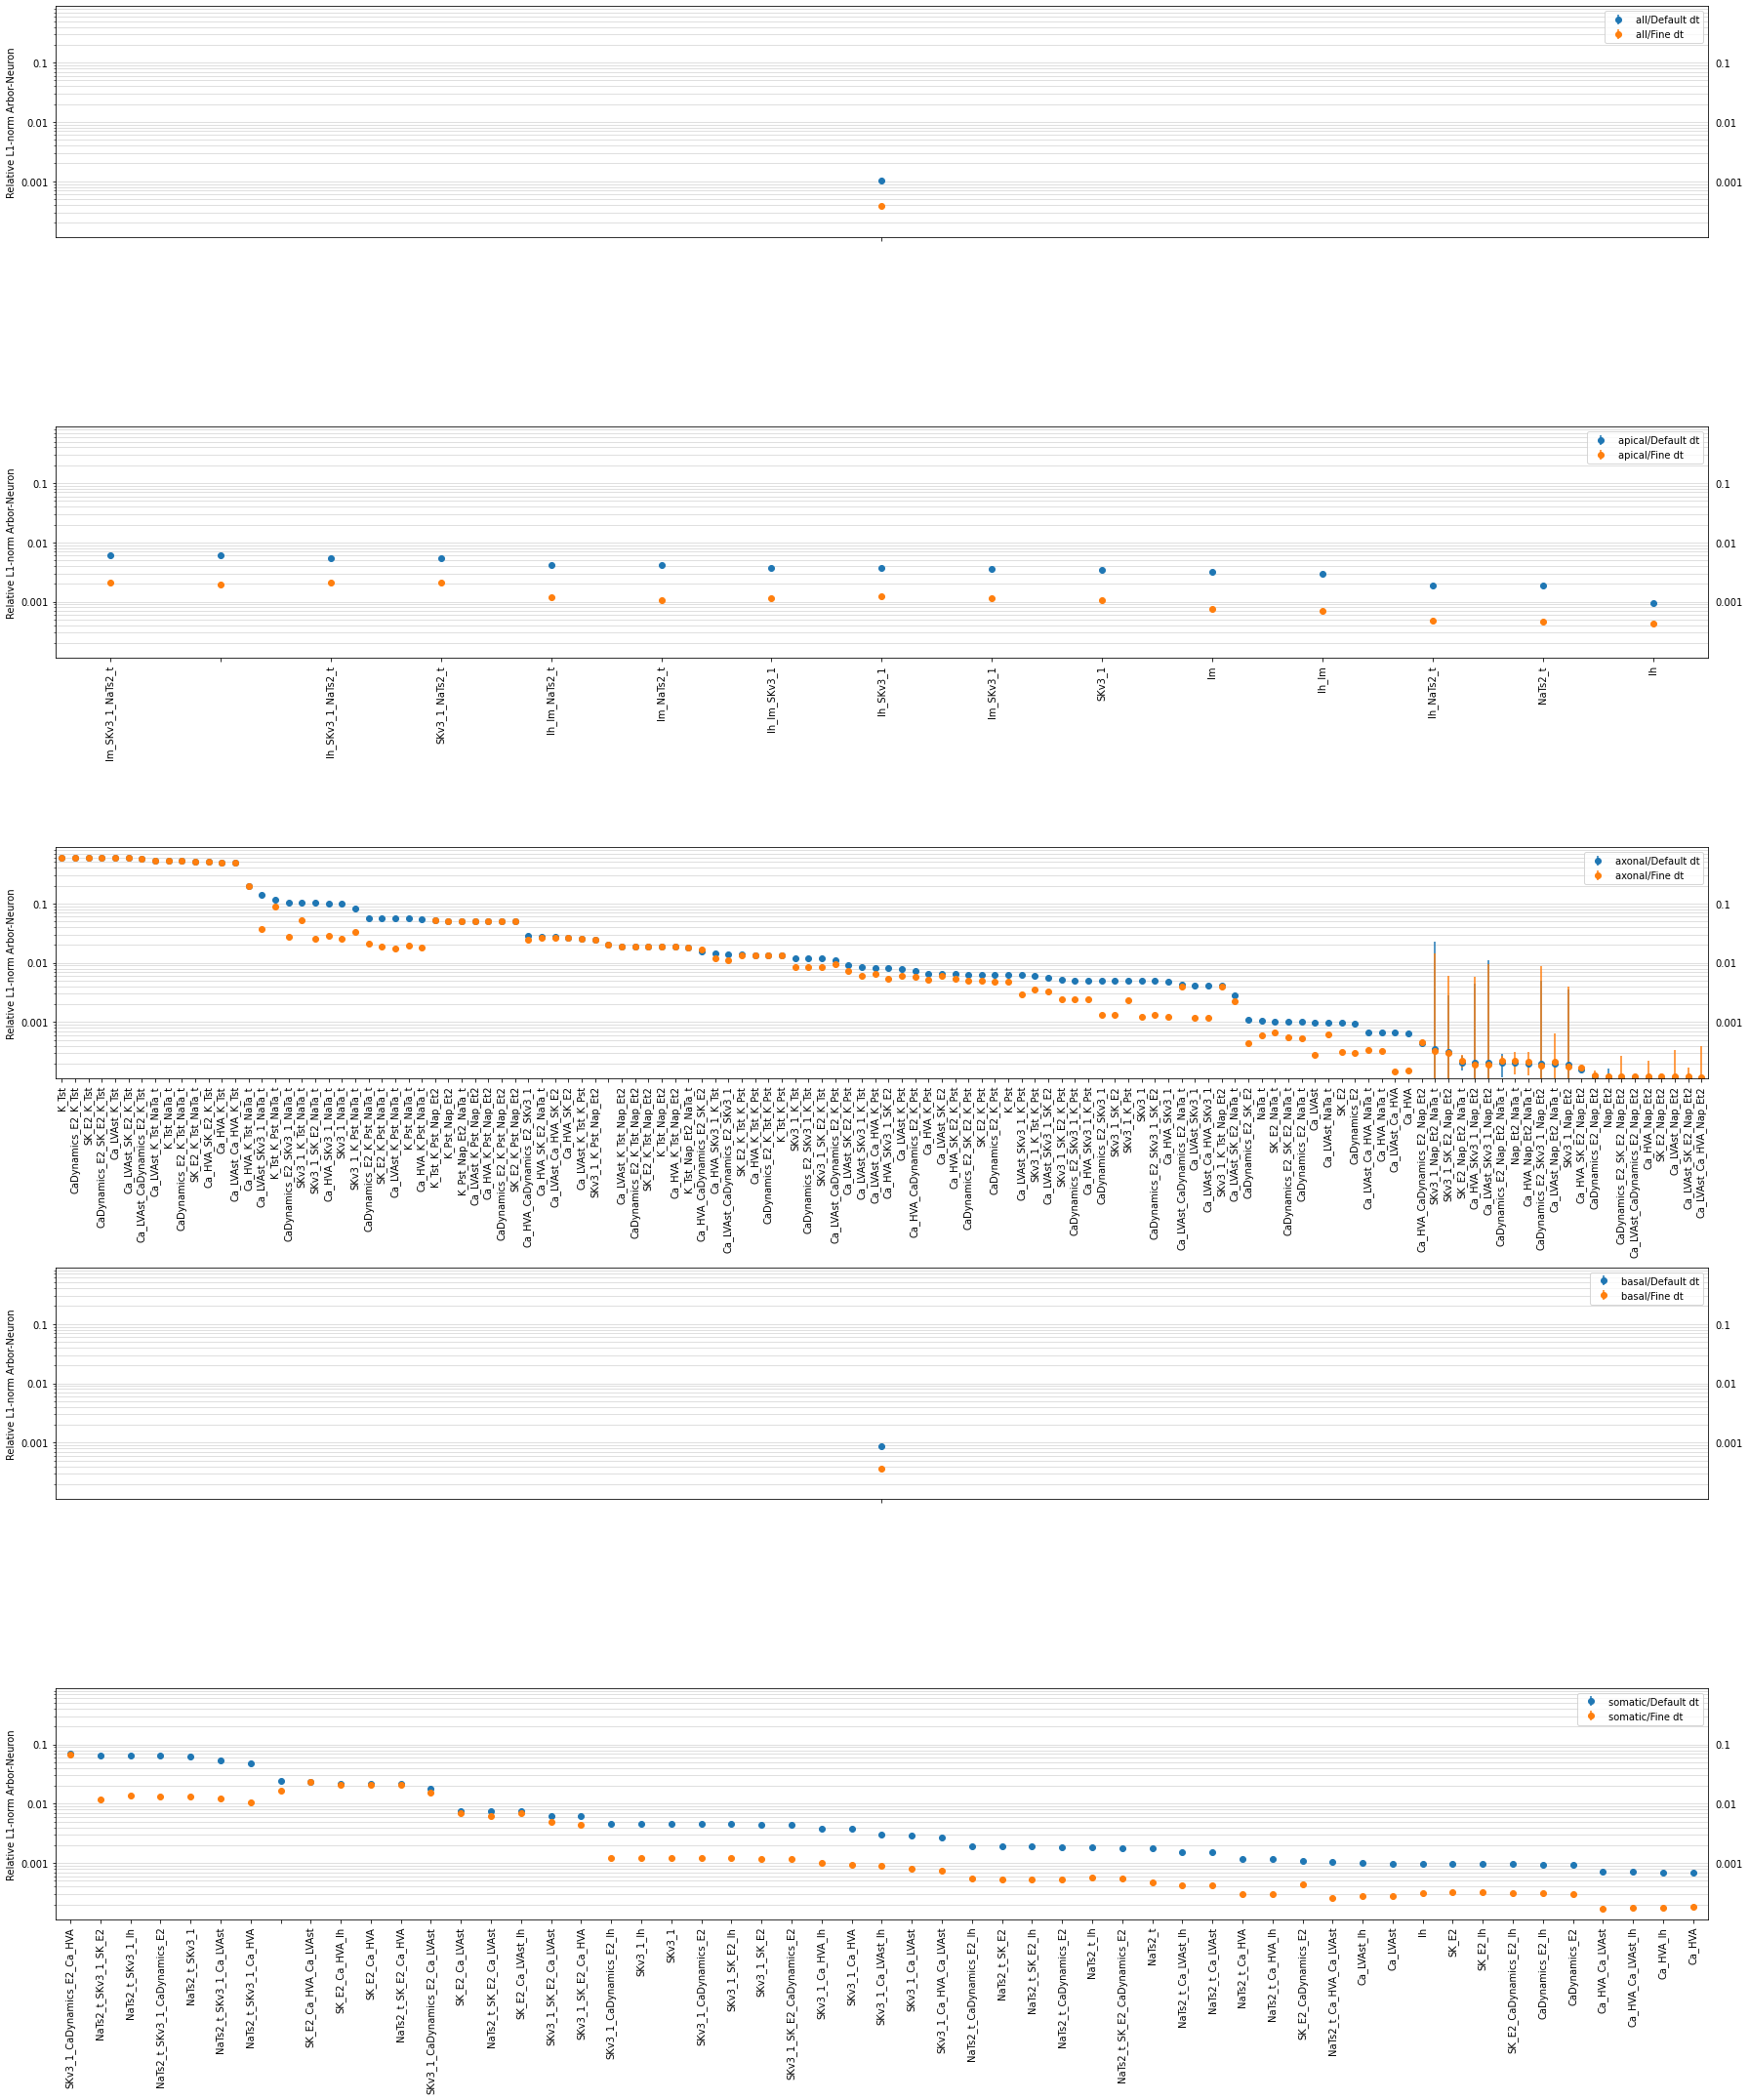

In [8]:
fig, axs = plt.subplots(len(regional_test_status), 1, sharey=True, figsize=(25, 6*len(regional_test_status)))

def show_test_status(ax, region, test_status_df, extra_label=''):
    for dt_setting, dt_group in test_status_df.groupby('dt_setting'):
        ax.errorbar(dt_group['mechs_str'],
                    dt_group['l1_norm'], yerr=dt_group['l1_error'], fmt='o', label= region + '/' + dt_setting + ' dt' + extra_label)
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(labelright=True)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2g"))
    ax.grid(visible=True, which='both', axis='y', alpha=0.5)
    ax.set_ylabel('Relative L1-norm Arbor-Neuron')
    ax.set_xlim(-0.5,len(dt_group)-0.5)
    ax.legend()
    

for i, (region, regional_test_status_df) in enumerate(regional_test_status.items()):
    show_test_status(axs[i], region, regional_test_status_df)
fig.tight_layout()
plt.show()

Repeating these plots on `axonal` and `somatic` regions for only the combinations with the highest-ranked mechanisms helps to get a better overview.

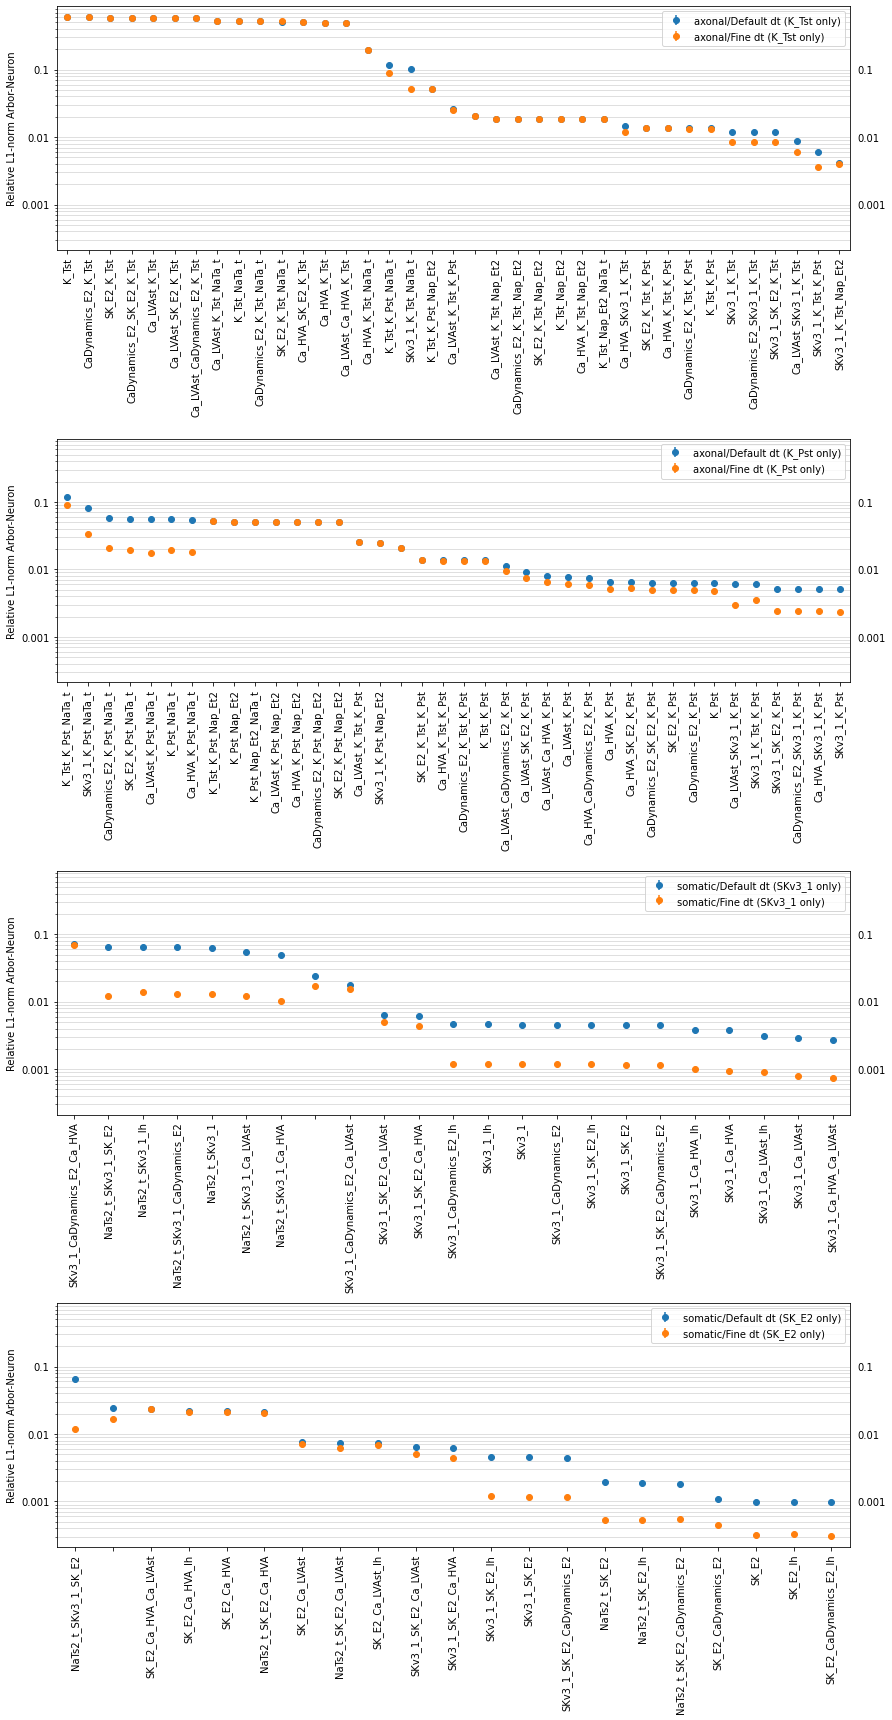

In [9]:
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12.5, 6*4))

mech_rank_stats['axonal']['Fine']['mech'].head(2)
mech_rank_stats['somatic']['Fine']['mech'].head(2)

i = 0
for region in ['axonal', 'somatic']:
    for mech in mech_rank_stats[region]['Fine']['mech'].head(2):
        show_test_status(axs[i],
                         region,
                         regional_test_status[region][regional_test_status[region]['mechs'].apply(lambda mechs: mech in mechs[region])],
                         ' (' + mech + ' only)')
        i += 1
        
fig.tight_layout()
plt.show()

Tests with N/A result obtained above:

In [10]:
%%bash

cat tests_na

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2_SK_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_SK_E2_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_SK_E2_CaDynamics_E2_Ca_LVAst

Usually this is due to failing to advance time-integration in NEURON. Printing all other cases here.

In [11]:
%%bash

for f in $(cat tests_na); do
    if ! grep NEURON:\ variable\ step\ integrator\ error $f > /dev/null; then
         echo $f
    fi
done

The error messages contain more info.

In [12]:
%%bash

grep -C 1 CVode $(cat tests_na)

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x2b1fc00 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode-- At t = 86.3555 and h = 8.33474e-09, the corrector\n",
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-      "convergence failed repeatedly or with |h| = hmin.\n",
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x2b1fc00 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbo